## Create graph

In [5]:
import networkx as nx
import pickle as pkl
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from itertools import combinations
from matplotlib import pyplot as plt

def open_dict(file):
    with open(file, 'rb') as f:
        d = pkl.load(f)
    return d

def match(clusters_dict, cluster1, cluster2):

    pdbs2 = [np.unique(pdb[ : 4]) for pdb, _ in clusters_dict[cluster2]]
    for pdb, _ in clusters_dict[cluster1]:
        if pdb[ : 4] in pdbs2:
            return True
    
    return False

def adj_mat(clusters_dict):
    seen_dict = defaultdict(set)
    edge_labels = defaultdict(list)
    keys = sorted(list(clusters_dict.keys()))
    for i in tqdm(range(len(keys))):
        cluster_name = keys[i]
        chains = clusters_dict[cluster_name]
        for pdb, _ in chains:
            seen_dict[pdb].add(i)
    adj_mat = np.zeros((len(keys), len(keys)))
    pdb_keys = list(seen_dict.keys())
    for pdb_i in tqdm(range(len(seen_dict))):
        pdb = pdb_keys[pdb_i]
        cluster_list = seen_dict[pdb]
        for i, j in combinations(cluster_list, 2):
            adj_mat[i, j] += 1
            edge_labels[(keys[i], keys[j])].append(pdb)
    edge_labels.update({(y, x): v for (x, y), v in edge_labels.items()})

    # keys = list(clusters_dict.keys())
    # n = len(keys)
    # adj_mat = np.zeros((n, n))

    # for i in tqdm(range(len(keys))):
    #     cluster1 = keys[i]
    #     for j, cluster2 in enumerate(keys[i + 1 : ]):
    #         if match(clusters_dict, cluster1, cluster2):
    #             adj_mat[i, j] = 1
    #             adj_mat[j, i] = 1
    
    return adj_mat, edge_labels, keys

def graph(train_dict, valid_dict, test_dict):

    n_train = len(train_dict.keys())
    n_valid = len(valid_dict.keys())
    n_test = len(test_dict.keys())
    edge_labels = {}
    print('train')
    adj_mat_train, edge_labels_train, node_labels = adj_mat(train_dict)
    graph_train = nx.from_numpy_matrix(adj_mat_train)
    graph_train = nx.relabel_nodes(graph_train, {i: x for i, x in enumerate(node_labels)})
    edge_labels.update(edge_labels_train)
    print('valid')
    adj_mat_valid, edge_labels_valid, node_labels = adj_mat(valid_dict)
    graph_valid = nx.from_numpy_matrix(adj_mat_valid)
    graph_valid = nx.relabel_nodes(graph_valid, {i: x for i, x in enumerate(node_labels)})
    edge_labels.update(edge_labels_valid)
    print('test')
    adj_mat_test, edge_labels_test, node_labels = adj_mat(test_dict)
    graph_test = nx.from_numpy_matrix(adj_mat_test)
    graph_test = nx.relabel_nodes(graph_test, {i: x for i, x in enumerate(node_labels)})
    edge_labels.update(edge_labels_test)
    G = nx.compose(graph_train, graph_valid)
    G = nx.compose(G, graph_test)
    return G, edge_labels

train_dict = open_dict('data/best_prot/splits_dict/train.pickle')
valid_dict = open_dict('data/best_prot/splits_dict/valid.pickle')
test_dict = open_dict('data/best_prot/splits_dict/test.pickle')
total_graph, edge_labels = graph(train_dict, valid_dict, test_dict)

train


100%|██████████| 123275/123275 [00:00<00:00, 1118517.96it/s]


valid


100%|██████████| 7042/7042 [00:00<00:00, 1051076.07it/s]


test


100%|██████████| 6777/6777 [00:00<00:00, 1424587.69it/s]


## Open saved graph and create color map

In [37]:
import networkx as nx

color_map = ['darkblue'] * len(train_dict.keys()) + ['limegreen'] * len(valid_dict.keys()) + ['crimson'] * len(test_dict.keys())

## Draw total graph

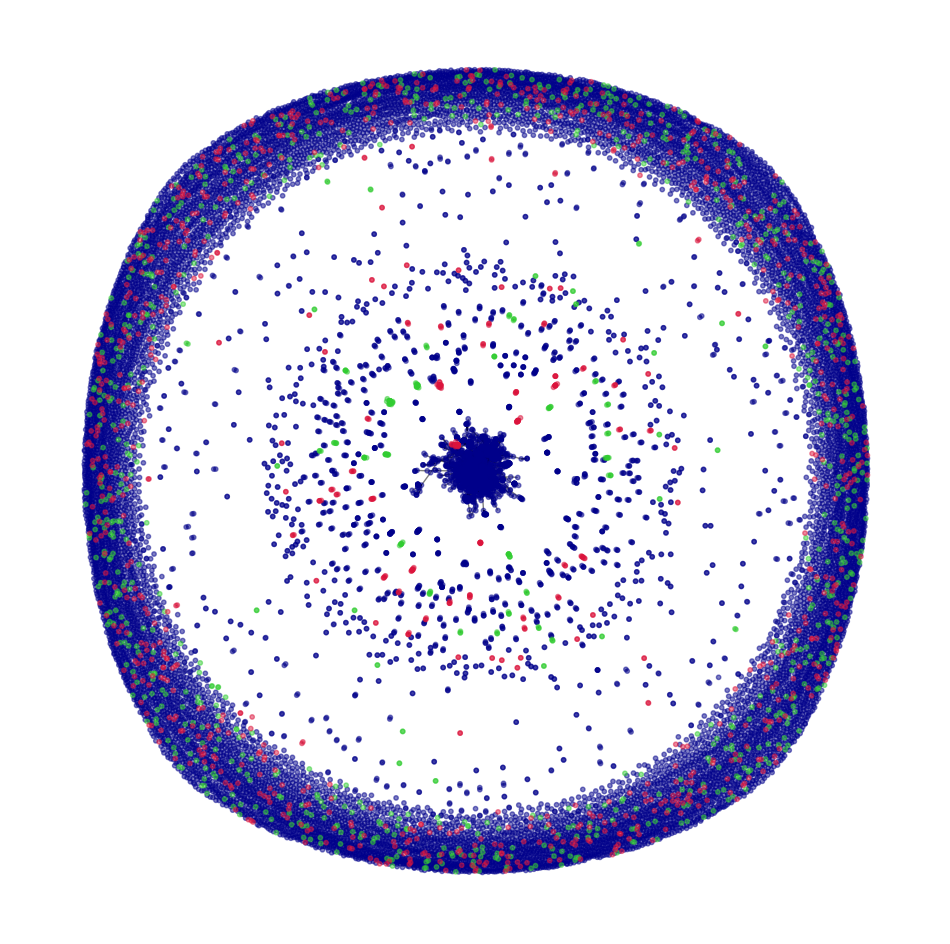

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
nx.draw_networkx(total_graph, node_color=color_map, node_size=10, alpha=.5, with_labels=False)
plt.axis("off")
plt.show()

## Draw graph of first 3 connected components

In [2]:
subgraphs = [total_graph.subgraph(c) for c in sorted(nx.connected_components(total_graph), key=len, reverse=True)]

In [3]:
sorted(total_graph.degree, key=lambda x: x[1], reverse=True)[:10]

[('5bv7_C', 383),
 ('5w5x_L', 381),
 ('6ol7_I', 248),
 ('6jl3_A', 121),
 ('5xj4_L', 76),
 ('6sy3_A', 56),
 ('1hh4_A', 52),
 ('7rh7_R-L', 51),
 ('2onu_A', 47),
 ('2hxs_A', 44)]

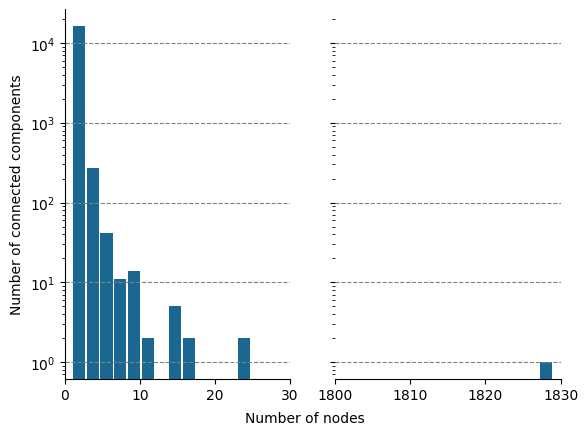

In [7]:
bin_edges = np.linspace(0, 1830, 1830 // 5 + 1) # make the bins
bin_centres = np.linspace(2.5, 1832.5, 1830 // 5) # for plotting only
my_hist = np.histogram([len(x) for x in nx.connected_components(total_graph)], bins = bin_edges)[0]

f, (ax, ax2) = plt.subplots(1, 2, facecolor = 'w', sharey=True) # make the axes
ax.hist([len(x) for x in nx.connected_components(total_graph)], bins=1000, log=True, rwidth=0.9,
                   color="#1A6891") # plot on top axes
ax2.hist([len(x) for x in nx.connected_components(total_graph)], bins=1000, log=True, rwidth=0.9,
                   color="#1A6891") # plot on bottom axes
ax.set_xlim([0, 30]) # numbers here are specific to this example
ax2.set_xlim([1800, 1830]) # numbers here are specific to this example
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax2.yaxis.grid(color='gray', linestyle='dashed')
    
f.text(0.5, 0.02, 'Number of nodes', ha='center')
ax.set_ylabel("Number of connected components")
plt.show()

plt.show()

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

def draw_graph(graph, color_nodes=None, with_labels=False, opt_distance=None):
    plt.figure(figsize=(12, 12))
    edges,weights = zip(*nx.get_edge_attributes(graph,'weight').items())
    weights = np.clip(weights, a_max=20, a_min=0) / 20
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#1A6891", "#5DAC43", "#FDCF44"])
    colors = [cmap(x) for x in weights]
    bright_colors = ["#CE2D4F", "#FF9F1C"]
    if color_nodes is not None:
        node_colors = ['#333333' if x not in color_nodes else bright_colors[color_nodes.index(x)] for x in graph]
        node_sizes = [10 if x not in color_nodes else 50 for x in graph]
    else:
        node_colors = "#333333"
        node_sizes = 10
    nx.draw_networkx(graph, node_size=node_sizes, alpha=0.6, with_labels=with_labels, edge_color=colors, width=2, node_color=node_colors, pos = nx.spring_layout(graph, k=opt_distance))
    plt.axis("off")
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=20))
    sm._A = []
    plt.colorbar(sm)
    plt.show()

/tmp/ipykernel_351963/2983235956.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


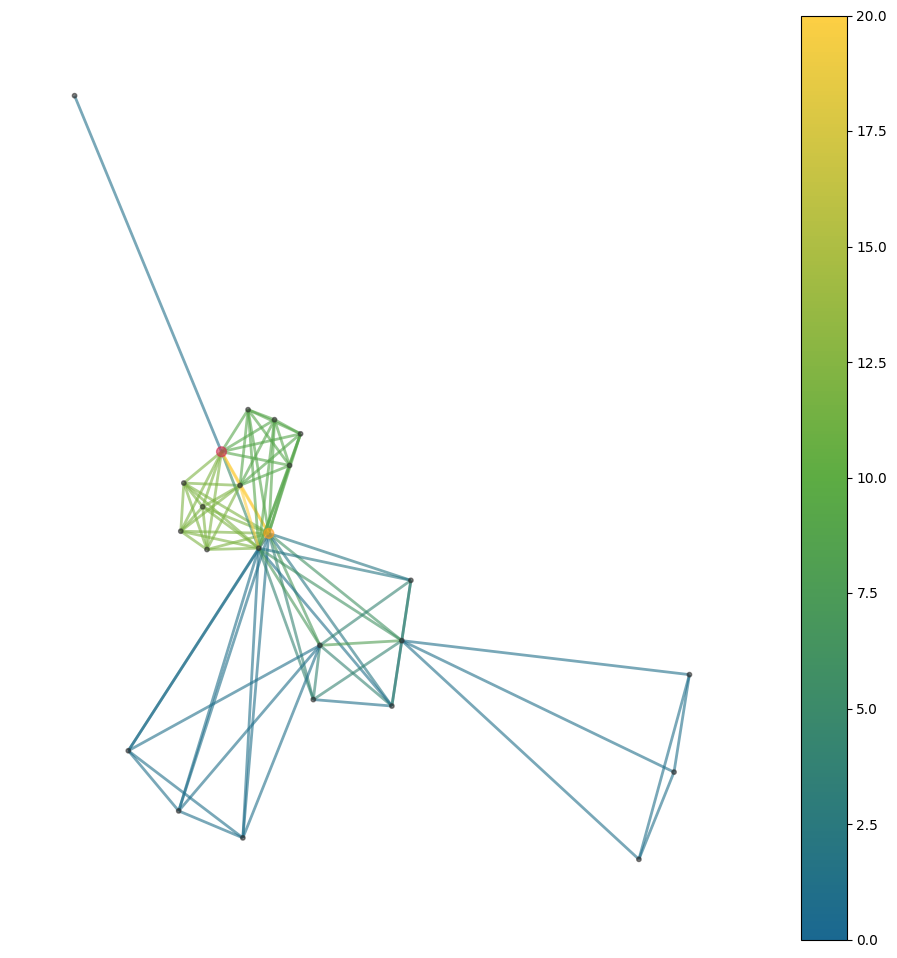

In [12]:
draw_graph(subgraphs[2], color_nodes=["5zwl_G", "1fx0_B"])


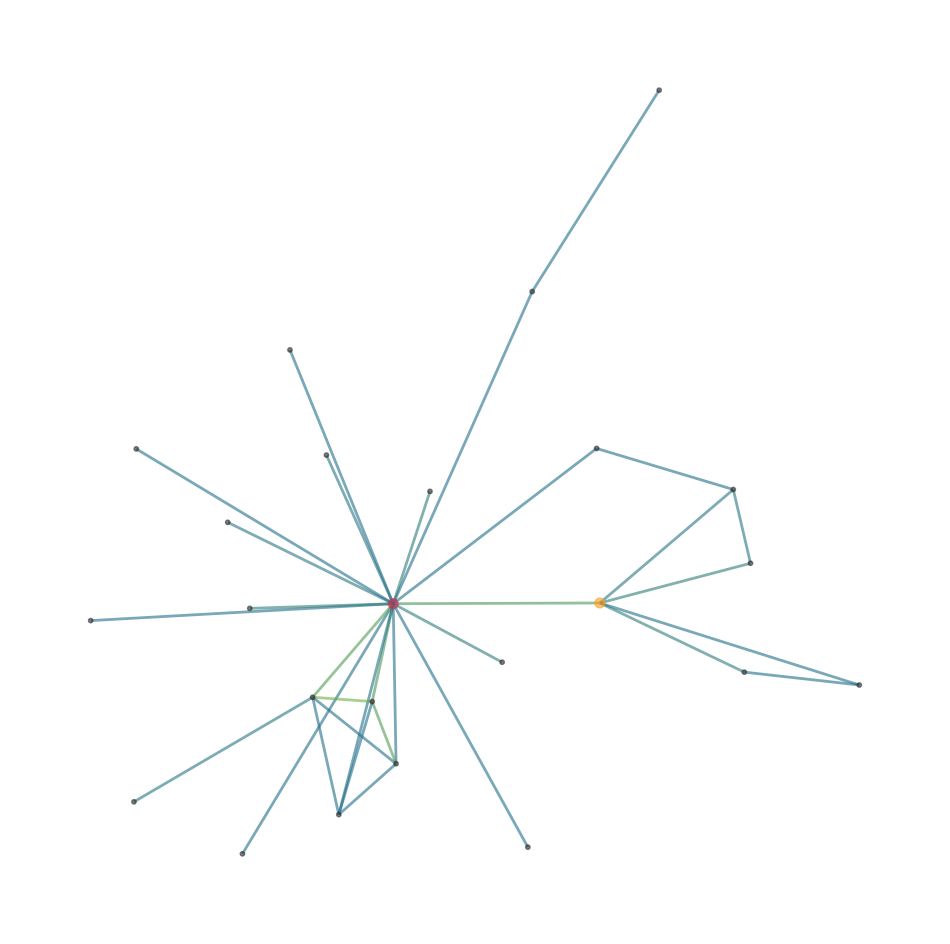

In [136]:
draw_graph(subgraphs[1], color_nodes=['6lvu_A', "1tqy_D"])

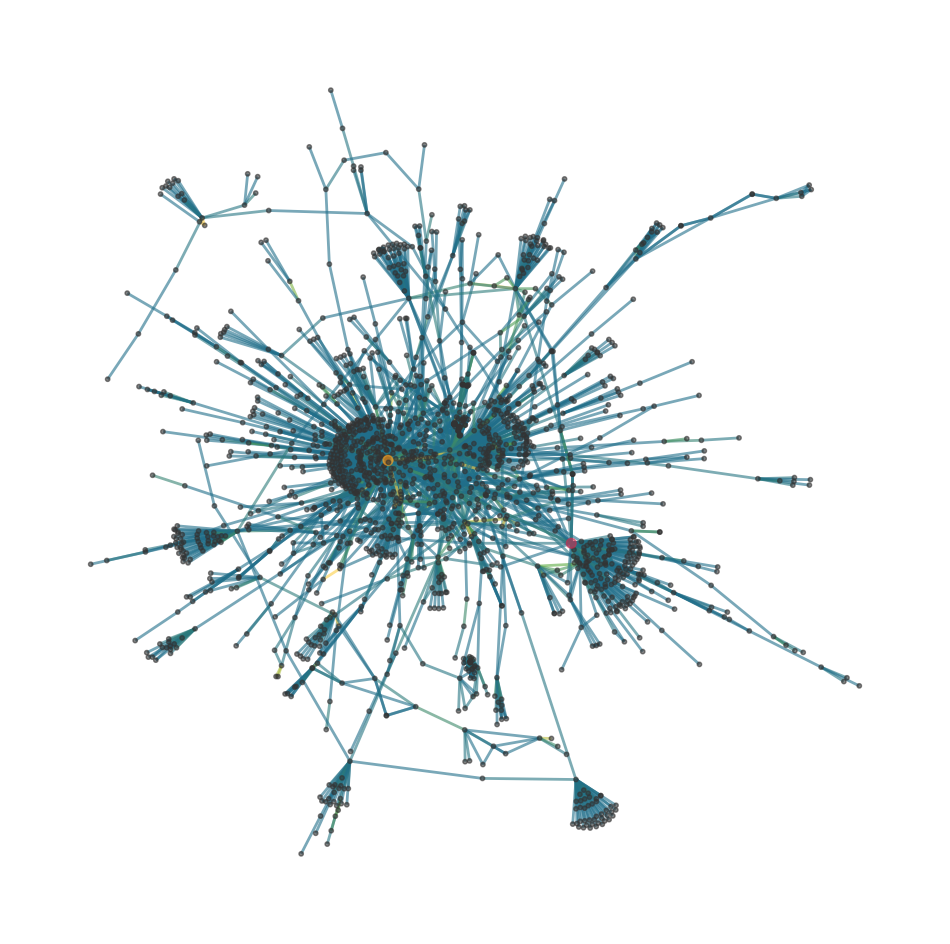

In [140]:
draw_graph(subgraphs[0], color_nodes=["6jl3_A", "5w5x_L"], opt_distance=None)

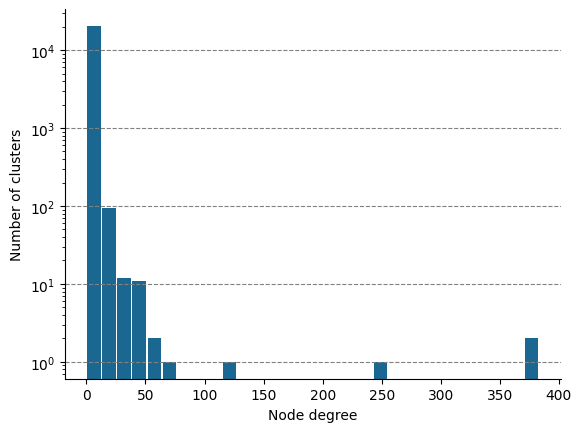

In [8]:
lengths = []
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(color='gray', linestyle='dashed')
    
plt.hist([x[1] for x in total_graph.degree], bins=30, rwidth=0.9,
                   color="#1A6891")
plt.yscale('log')
plt.xlabel("Node degree")
plt.ylabel("Number of clusters")
plt.show()